## 以KNN演算法實作書籍推薦
### 程式修改自[Building A Book Recommender System – The Basics, kNN and Matrix Factorization](https://datascienceplus.com/building-a-book-recommender-system-the-basics-knn-and-matrix-factorization)

## 載入相關套件

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 載入資料集

In [13]:
# 書籍資料
books = pd.read_csv('./data/BX-Books.csv', sep=';', on_bad_lines='skip', 
                    low_memory=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 
                 'imageUrlS', 'imageUrlM', 'imageUrlL']

# 讀者資料
users = pd.read_csv('./data/BX-Users.csv', sep=';', on_bad_lines='skip', 
                    encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

# 評價資料
ratings = pd.read_csv('./data/BX-Book-Ratings.csv', sep=';', on_bad_lines='skip', 
                      encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

## 資料探索與分析

In [14]:
# 評價資料筆數
print(ratings.shape)

(1149780, 3)


In [15]:
ratings.head(10)

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


Text(0, 0.5, 'Count')

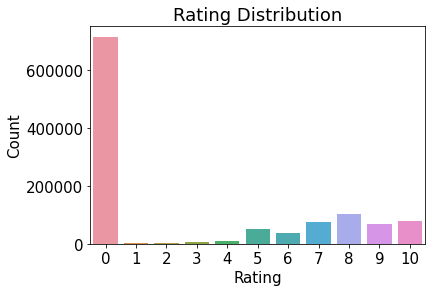

In [16]:
# 評價筆數繪圖
import seaborn as sns

plt.rc("font", size=15)
sns.countplot(x='bookRating', data=ratings)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

### 大部份書籍都未被評價

In [17]:
# 書籍資料筆數
print(books.shape)

(271360, 8)


In [18]:
# 讀者資料筆數
print(users.shape)

(278858, 3)


## 讀者年齡分析

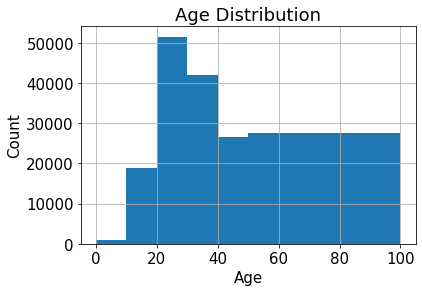

In [19]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

## 最多人評分的書籍

In [20]:
rating_count = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
top_rating = rating_count.sort_values('bookRating', ascending=False).head()
top_rating

,bookRating
ISBN,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723


## 最多人評分的書籍明細

In [21]:
most_rated_books = pd.DataFrame(top_rating.index, index=np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, books, on='ISBN')
most_rated_books_summary

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
1,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
2,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
3,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
4,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...


## 書籍評價的平均得分

In [22]:
average_rating = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,bookRating,ratingCount
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


# 觀察: 最多人評分書籍的平均得分並沒有相對比較高

## 為確保統計顯著性，只保留讀者評分超過200次者，書籍評分超過100次者

In [23]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

## User-Item matrix

In [24]:
ratings_pivot = ratings.pivot(index='userID', columns='ISBN').bookRating
userID = ratings_pivot.index
ISBN = ratings_pivot.columns
print(ratings_pivot.shape)
ratings_pivot.head()

(905, 207699)


ISBN,0330299891,0375404120,0586045007,9022906116,9032803328,9044922564,9044922572,9044922718,9044923161,904492401X,...,UNGRANDHOMMED,X000000000,"YOUTELLEM,AND",ZR903CX0003,"\0432534220\""""","\2842053052\""""",b00005wz75,cn108465,cn113107,Ô½crosoft
userID,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 任選一本書 0316666343，計算與其他書籍的相關係數

In [25]:
test_book = '0316666343'
bones_ratings = ratings_pivot[test_book]
# 計算與其他書籍的相關係數
similar_to_bones = ratings_pivot.corrwith(bones_ratings)
corr_bones = pd.DataFrame(similar_to_bones, columns=['pearsonR'])
corr_bones.dropna(inplace=True)

# 結合書籍評價的平均得分
corr_summary = corr_bones.join(average_rating['ratingCount'])

# 只保留評價的平均得分>=300
high_corr_book = corr_summary[corr_summary['ratingCount']>=300] \
        .sort_values('pearsonR', ascending=False).head(10)
high_corr_book

C:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


,pearsonR,ratingCount
ISBN,,
0316666343,1.000000,1295
0312291639,0.471872,354
0316601950,0.434248,568
0446610038,0.429712,391
0446672211,0.421478,585
0385265700,0.351635,319
0345342968,0.316922,321
0060930535,0.309860,494
0375707972,0.308145,354


## 取得書名

In [26]:
# 取得書名，扣除自己，取前9名
books_corr_to_bones = pd.DataFrame(high_corr_book.index[1:], 
                                  index=np.arange(9), columns=['ISBN'])
corr_books = pd.merge(books_corr_to_bones, books, on='ISBN')
corr_books

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0312291639,The Nanny Diaries: A Novel,Emma McLaughlin,2003,St. Martin's Griffin,http://images.amazon.com/images/P/0312291639.0...,http://images.amazon.com/images/P/0312291639.0...,http://images.amazon.com/images/P/0312291639.0...
1,0316601950,The Pilot's Wife : A Novel,Anita Shreve,1999,Back Bay Books,http://images.amazon.com/images/P/0316601950.0...,http://images.amazon.com/images/P/0316601950.0...,http://images.amazon.com/images/P/0316601950.0...
2,0446610038,1st to Die: A Novel,James Patterson,2002,Warner Vision,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...
3,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...
4,0385265700,The Book of Ruth (Oprah's Book Club (Paperback)),Jane Hamilton,1990,Anchor,http://images.amazon.com/images/P/0385265700.0...,http://images.amazon.com/images/P/0385265700.0...,http://images.amazon.com/images/P/0385265700.0...
5,0345342968,Fahrenheit 451,RAY BRADBURY,1987,Del Rey,http://images.amazon.com/images/P/0345342968.0...,http://images.amazon.com/images/P/0345342968.0...,http://images.amazon.com/images/P/0345342968.0...
6,0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...
7,0375707972,The Reader,Bernhard Schlink,1999,Vintage Books USA,http://images.amazon.com/images/P/0375707972.0...,http://images.amazon.com/images/P/0375707972.0...,http://images.amazon.com/images/P/0375707972.0...
8,0684872153,Angela's Ashes (MMP) : A Memoir,Frank McCourt,1999,Scribner,http://images.amazon.com/images/P/0684872153.0...,http://images.amazon.com/images/P/0684872153.0...,http://images.amazon.com/images/P/0684872153.0...


# KNN

In [27]:
# 合併評價表及書籍基本資料
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 
           'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...


In [28]:
# 去除未評價書籍
combine_book_rating = combine_book_rating.dropna(axis = 0, 
                                     subset = ['bookTitle'])
# 統計書籍的評價次數
book_ratingCount = (combine_book_rating.
     groupby(by = ['bookTitle'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['bookTitle', 'totalRatingCount']]
    )
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [29]:
# 合併評價次數及書籍基本資料
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, 
             left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [30]:
# 顯示評價次數的統計量
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   160576.000
mean         3.044
std          7.428
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        365.000
Name: totalRatingCount, dtype: float64


In [31]:
# 顯示百分位數
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    5.000
0.910    6.000
0.920    7.000
0.930    7.000
0.940    8.000
0.950   10.000
0.960   11.000
0.970   14.000
0.980   19.000
0.990   31.000
Name: totalRatingCount, dtype: float64


## 熱門書籍：只有1%的書籍有超過50次的評分

In [32]:
# 篩選有超過50次評分的書籍
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query(
    'totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


## 合併熱門書籍及讀者基本資料，使用美國及加拿大資料

In [33]:
# 合併熱門書籍及讀者基本資料
combined = rating_popular_book.merge(users, left_on = 'userID', 
                                     right_on = 'userID', how = 'left')

# 只考慮美國及加拿大讀者
us_canada_user_rating = combined[combined['Location'] \
                                 .str.contains("usa|canada")]
us_canada_user_rating=us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"gilbert, arizona, usa"
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"knoxville, tennessee, usa"
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"byron, minnesota, usa"
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"cordova, tennessee, usa"
5,16795,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"mechanicsville, maryland, usa"


In [34]:
us_canada_user_rating.shape

(56396, 6)

## KNN模型訓練

In [35]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# 去除重複值
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
# 產生商品與讀者的樞紐分析表，會有很多 null value，均以0替代
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', 
                                  columns = 'userID', values = 'bookRating').fillna(0)
# csr_matrix：壓縮稀疏矩陣，加速矩陣計算
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

# 找出相似商品，X為每一個讀者的評分
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

## 測試

In [47]:
# 隨機抽取一件商品作預測
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
distances, indices = model_knn.kneighbors(np.array(
    us_canada_user_rating_pivot.iloc[query_index, :])
      .reshape(1, -1), n_neighbors = 6)

# 顯示最相似的前5名商品，並顯示距離(相似性)
for i in range(0, len(distances.flatten())):
    if i == 0: # 第一筆是自己
        print(f'{us_canada_user_rating_pivot.index[query_index]} 的推薦:')
    else:
        print(f'{i}: {us_canada_user_rating_pivot.index[indices.flatten()[i]]}' + \
              f', 距離: {distances.flatten()[i]:.2f}:')

Full Tilt (Janet Evanovich's Full Series) 的推薦:
1: Full House (Janet Evanovich's Full Series), 距離: 0.61:
2: Beach House, 距離: 0.65:
3: The Next Accident, 距離: 0.66:
4: Faking It, 距離: 0.68:
5: Nerd in Shining Armor, 距離: 0.69:


# SVD 矩陣分解(Matrix Factorization)

In [37]:
# User-Item Matrix
us_canada_user_rating_pivot2 = us_canada_user_rating.pivot(
    index = 'userID', columns = 'bookTitle', values = 'bookRating').fillna(0)
us_canada_user_rating_pivot2.head()

bookTitle,1984,1st to Die: A Novel,2nd Chance,4 Blondes,84 Charing Cross Road,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Civil Action,A Cry In The Night,...,Winter Solstice,Wish You Well,Without Remorse,"Wizard and Glass (The Dark Tower, Book 4)",Wuthering Heights,Year of Wonders,You Belong To Me,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw"""
userID,,,,,,,,,,,,,,,,,,,,,
254,9.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2276,0.000,0.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2766,0.000,0.000,0.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2977,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000
3363,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [38]:
us_canada_user_rating_pivot2.shape

(734, 746)

In [39]:
X = us_canada_user_rating_pivot2.values.T
X.shape

(746, 734)

## TruncatedSVD 降維至 12 個

In [40]:
# 萃取 12 個特徵
import sklearn
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=12, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

(746, 12)

In [48]:
# 依據 12 個特徵計算相關係數
corr = np.corrcoef(matrix)
corr.shape

(746, 746)

## 測試

In [50]:
# 取得 "The Green Mile" 書籍索引值
us_canada_book_list = list(us_canada_user_rating_pivot2.columns)
coffey_hands = us_canada_book_list.index("The Green Mile")
print("The Green Mile 書籍索引值:", coffey_hands)

# 依照索引值找出與其他書的相關係數
corr_coffey_hands  = corr[coffey_hands]
corr_coffey_hands

The Green Mile 書籍索引值: 574


array([ 4.57506362e-01,  1.79638549e-01,  3.51122156e-01,  1.74309110e-01,
        5.27127814e-02,  3.56559079e-01,  5.74622207e-01,  2.35176949e-01,
        7.46193147e-02,  1.78793452e-01,  3.31512246e-01,  3.62801917e-01,
        1.70950100e-01, -2.07806863e-01, -2.17499804e-02, -1.16203501e-01,
        2.68289301e-01,  4.45544751e-01,  3.81921422e-01,  4.07682381e-01,
        4.30650836e-01,  5.16970279e-01,  1.04741649e-01,  9.36820714e-02,
        1.36732221e-02,  6.50714067e-01,  3.17588221e-01,  6.04925347e-01,
        1.41782812e-01,  2.41190943e-01,  2.60590937e-01,  2.91841726e-01,
        1.68842053e-01,  5.44502080e-01,  1.13941890e-01,  5.89212549e-01,
        6.18716181e-01,  4.46343794e-01,  5.39406651e-01,  7.61482954e-01,
        2.94367282e-01,  3.59907476e-01,  6.58322587e-01, -3.19750313e-04,
        1.02612097e-01,  2.66763127e-01,  2.68363079e-01,  3.14446459e-01,
        5.29288908e-01,  4.13817711e-01,  3.98420393e-01,  2.38703292e-02,
        3.62059623e-01, -

In [45]:
# 列出相關係數 > 80% 的書籍
us_canada_book_title = us_canada_user_rating_pivot2.columns
list(us_canada_book_title[(corr_coffey_hands >= 0.8)])

['Cujo',
 'It',
 'Pet Sematary',
 'Skeleton Crew',
 'The Green Mile',
 'The Talisman']